In [1]:
from pathlib import Path
import pickle

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("default")

In [2]:
# Paths
FILE_DIR = Path().absolute()
ROOT_DIR = FILE_DIR.parent
RES_DIR = ROOT_DIR / "results" / "dropout"

# Architectures
partition = ["mingjian"]
nnodes = [64, 128, 196]
archs = [
    f"{part}_partition_{n1}_{n2}_{n3}"
    for part in partition
    for n1 in nnodes
    for n2 in nnodes
    for n3 in nnodes
]

In [3]:
# Total number of parameters
ninput = 51
noutput = 1

nparams = []
for n1 in nnodes:
    for n2 in nnodes:
        for n3 in nnodes:
            nparams = np.append(nparams, (ninput*n1)+n1 + (n1*n2)+n2 + (n2*n3)+n3 + (n3*noutput)+noutput)

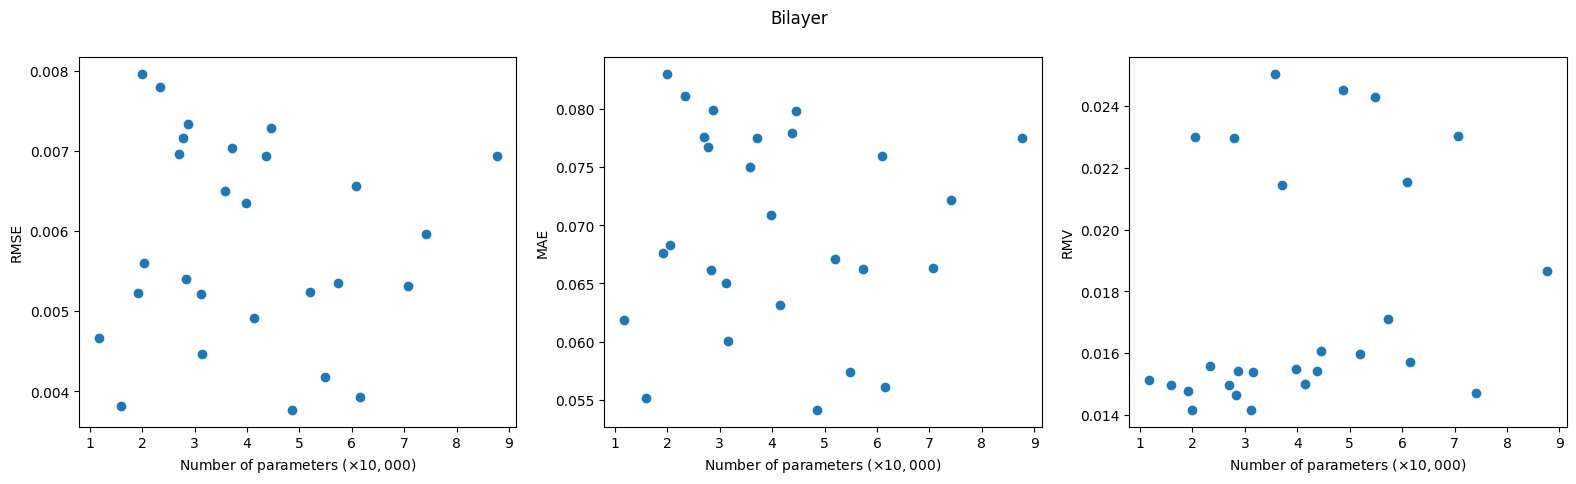

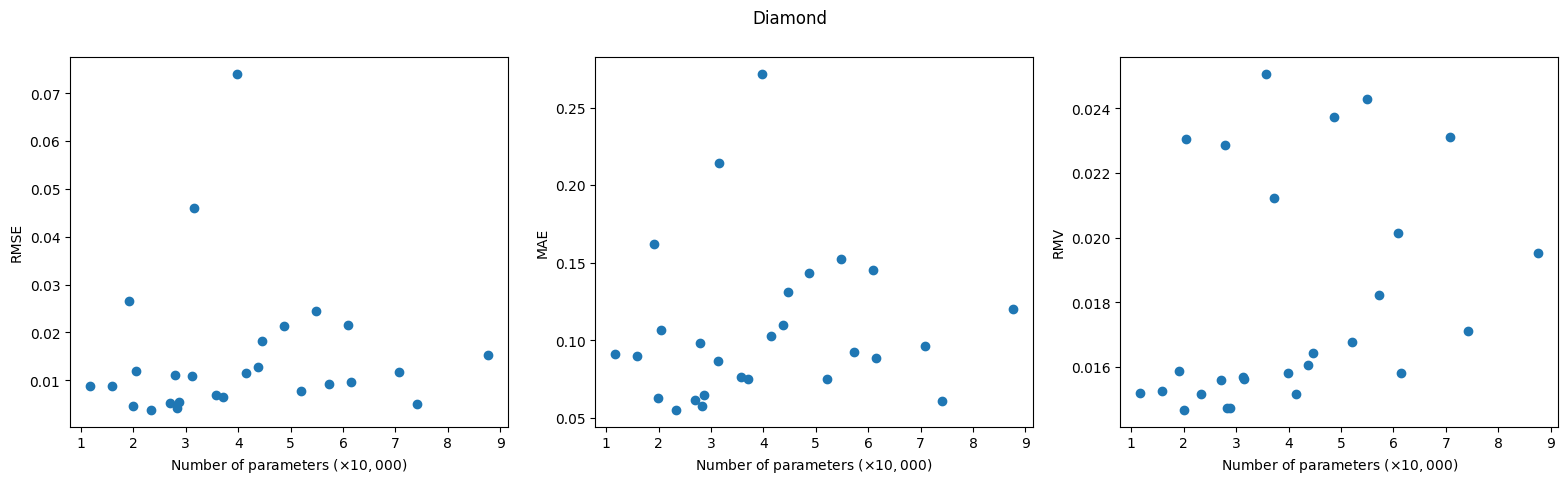

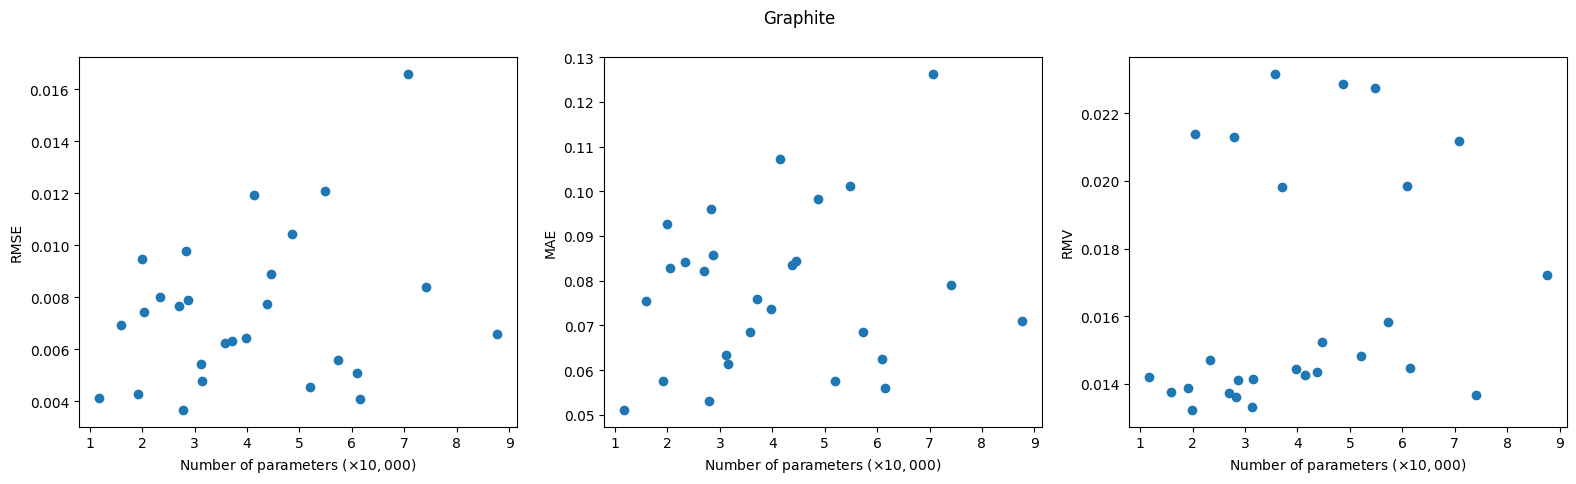

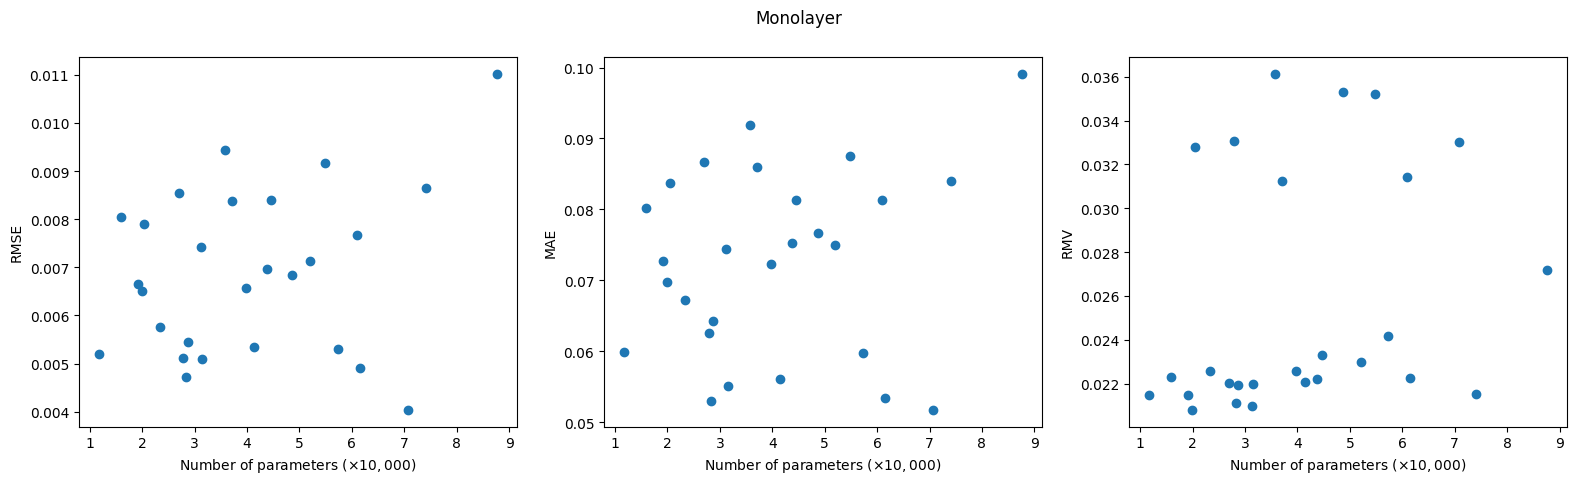

In [4]:
structures = ["bilayer", "diamond", "graphite", "monolayer"]

for struct in structures:
    energy_rmse = []
    energy_mae = []
    energy_rmv = []
    for arch in archs:
        with open(RES_DIR / arch / "uncertainty_energy_forces_test.pkl", "rb") as f:
            configs_dict = pickle.load(f)
        
        energy_ref = np.array([val["energy"] for val in configs_dict[struct].values()])
        natoms = np.array([val["natoms"] for val in configs_dict[struct].values()])
        energy_ens = np.array(
            [val["energy_ensembles"] for val in configs_dict[struct].values()]
        )
        energy_mean = np.mean(energy_ens, axis=1)
        energy_std = np.std(energy_ens, axis=1)
        
        energy_rmse = np.append(energy_rmse, np.sqrt(np.mean(((energy_ref - energy_mean) / natoms) ** 2)))
        energy_mae = np.append(energy_mae, np.sqrt(np.mean(np.abs((energy_ref - energy_mean) / natoms))))
        energy_rmv = np.append(energy_rmv, np.sqrt(np.mean(energy_std / natoms ** 2)))
    
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[6.4*3, 4.8])
    fig.suptitle(struct.capitalize())
    axes[0].plot(nparams / 1e4, energy_rmse, "o")
    axes[0].set_ylabel("RMSE")
    axes[1].plot(nparams / 1e4, energy_mae, "o")
    axes[1].set_ylabel("MAE")
    axes[2].plot(nparams / 1e4, energy_rmv, "o")
    axes[2].set_ylabel("RMV")
    
    for ax in axes:
        ax.set_xlabel(r"Number of parameters ($\times 10,000$)")
plt.show()

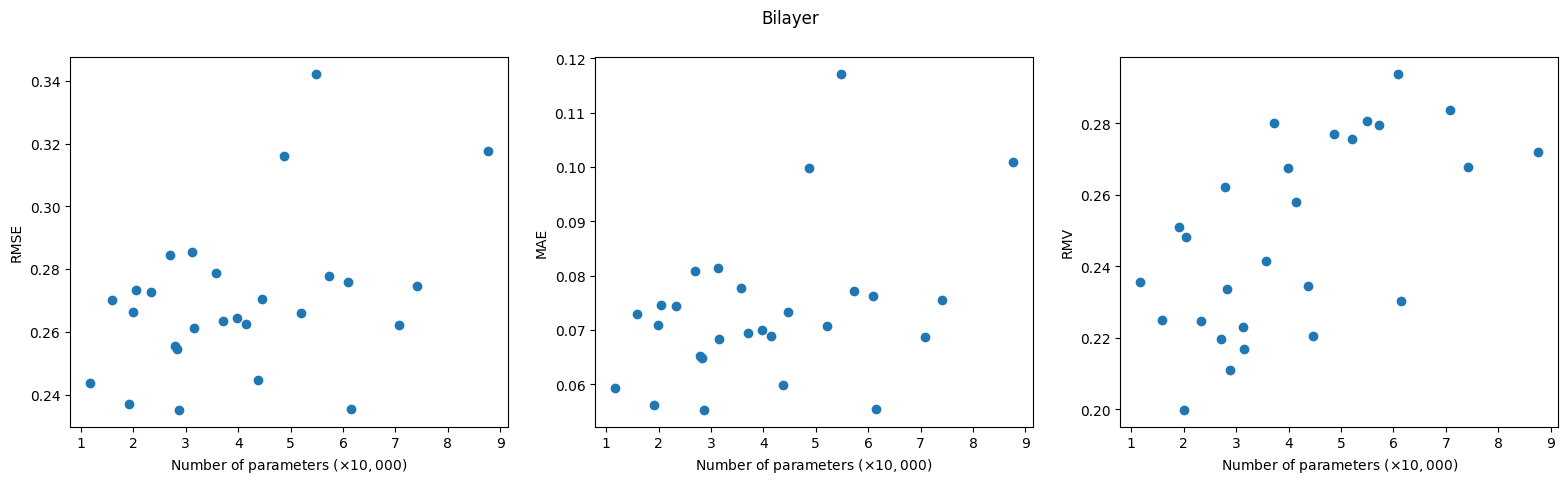

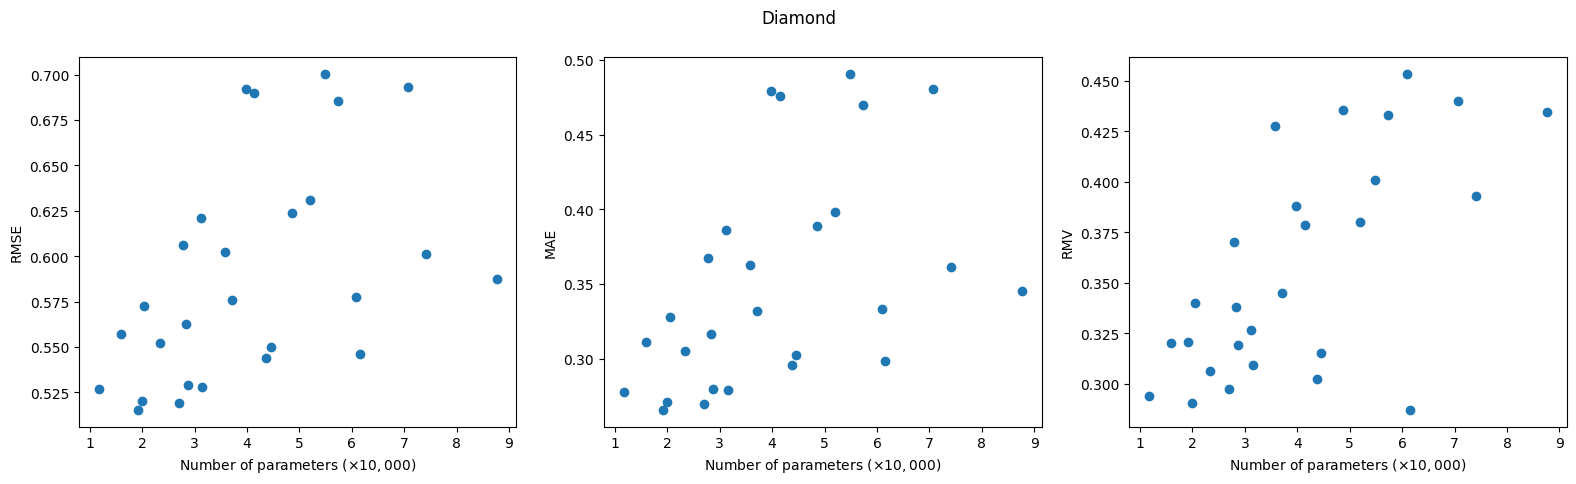

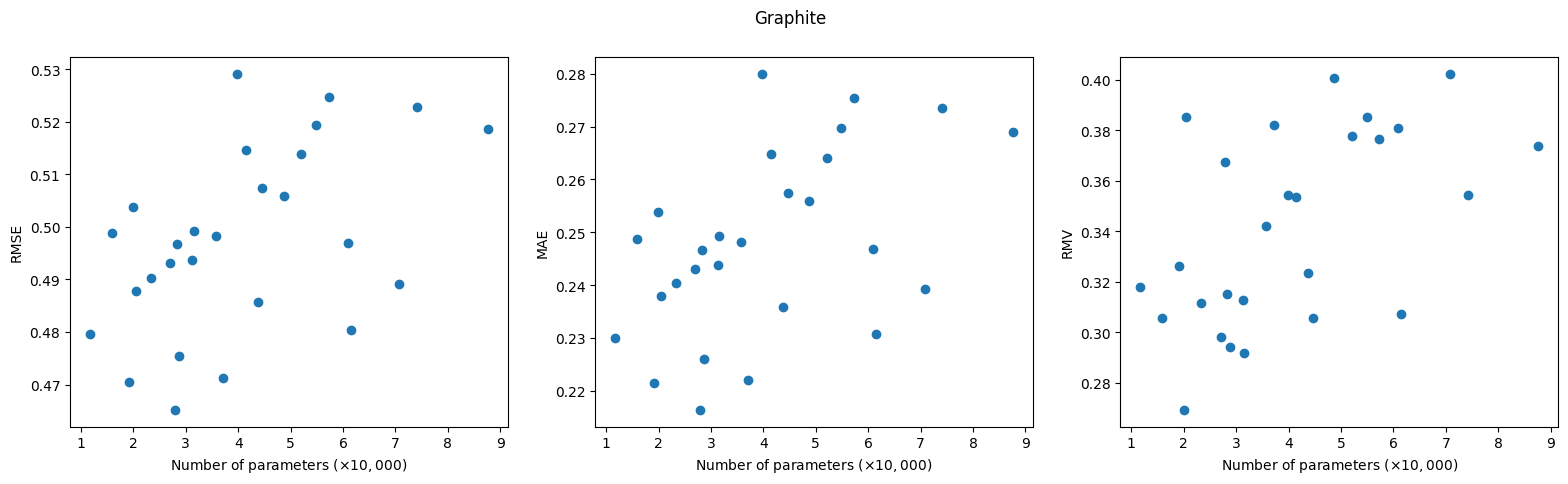

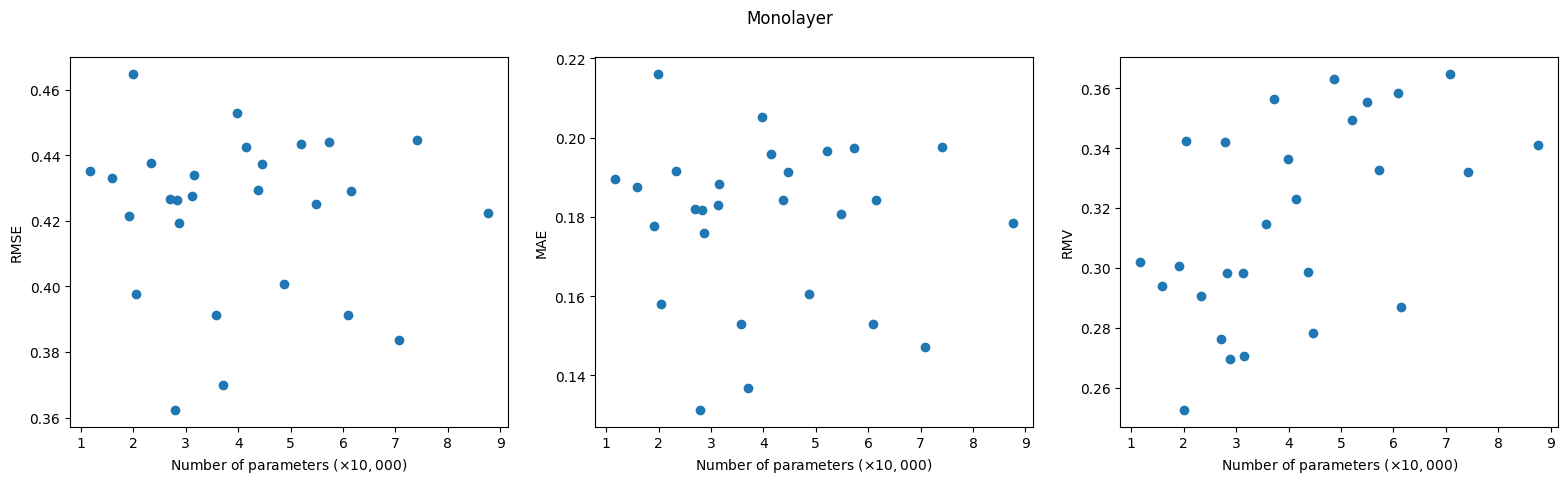

In [5]:
for struct in structures:
    forces_rmse = []
    forces_mae = []
    forces_rmv = []
    for arch in archs:
        with open(RES_DIR / arch / "uncertainty_energy_forces_test.pkl", "rb") as f:
            configs_dict = pickle.load(f)

        forces_ref = np.empty((0, 3))
        forces_ens = np.empty((100, 0, 3))
        for val in configs_dict[struct].values():
            # Reference
            forces_ref = np.concatenate((forces_ref, val["forces"]), axis=0)
            # Predictions
            forces_ens = np.concatenate((forces_ens, val["forces_ensembles"]), axis=1)

        forces_mean = np.mean(forces_ens, axis=0)
        forces_std = np.std(np.linalg.norm(forces_ens, axis=2), axis=0)
        
        forces_rmse = np.append(forces_rmse, np.sqrt(np.mean(np.linalg.norm(forces_ref - forces_mean, axis=1) **2)))
        forces_mae = np.append(forces_mae, np.mean(np.abs(np.linalg.norm(forces_ref - forces_mean, axis=1) **2)))
        forces_rmv = np.append(forces_rmv, np.sqrt(np.mean(forces_std ** 2)))
    
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[6.4*3, 4.8])
    fig.suptitle(struct.capitalize())
    axes[0].plot(nparams / 1e4, forces_rmse, "o")
    axes[0].set_ylabel("RMSE")
    axes[1].plot(nparams / 1e4, forces_mae, "o")
    axes[1].set_ylabel("MAE")
    axes[2].plot(nparams / 1e4, forces_rmv, "o")
    axes[2].set_ylabel("RMV")
    
    for ax in axes:
        ax.set_xlabel(r"Number of parameters ($\times 10,000$)")
plt.show()